## Transfer learning
## Whales vs Sharks

In [1]:
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from numpy.linalg import norm
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
print(tf.__version__)

2.1.0


In [2]:
import utils
import os
import pathlib

import IPython.display as display
from PIL import Image

In [3]:
data_dir = './data'
data_path = pathlib.Path(data_dir)

### Всего было собрано 1132 изображения.
### Они были разбиты на обучающую и тестовую выборку:

In [4]:
image_count = len(list(data_path.glob('train/*/*.jpg')))
image_count

632

In [5]:
image_count = len(list(data_path.glob('test/*/*.jpg')))
image_count

500

In [6]:
whale_files = list(data_path.glob('*/*/whale*.jpg'))
shark_files = list(data_path.glob('*/*/shark*.jpg'))    

### Примеры изображений

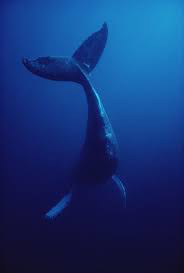

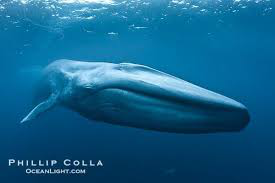

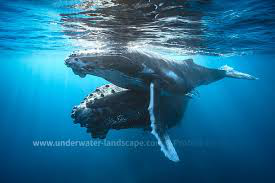

In [7]:
for image_path in whale_files[:3]:
    image = Image.open(str(image_path))
    display.display(image)

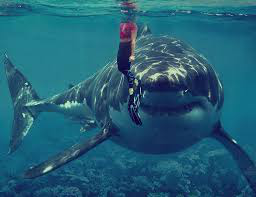

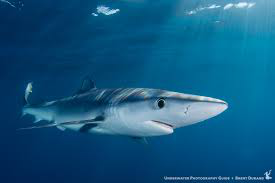

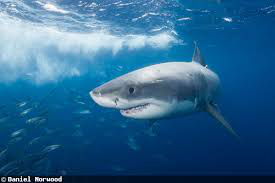

In [8]:
for image_path in shark_files[:3]:
    image = Image.open(str(image_path))
    display.display(image)

### Все изображения приведём к одному размеру 299 x 299 пикселя.
### Это - размер по умолчанию для Inception Resnet v2.

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = (299, 299)

In [10]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(    
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True    
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True    
)

In [11]:
CLASS_NAMES = np.array([item.name for item in data_path.glob('train/*')])
CLASS_NAMES

array(['shark', 'whale'], dtype='<U5')

In [12]:
train_generator = train_datagen.flow_from_directory(
    pathlib.Path(data_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,    
    classes=list(CLASS_NAMES),
    interpolation='bicubic'
)

Found 632 images belonging to 2 classes.


In [13]:
test_generator = test_datagen.flow_from_directory(
    pathlib.Path(data_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=list(CLASS_NAMES),
    interpolation='bicubic'
)

Found 500 images belonging to 2 classes.


In [14]:
STEPS_PER_EPOCH = 2 * train_generator.n // BATCH_SIZE
VALIDATION_STEPS = 2 * test_generator.n // BATCH_SIZE

In [15]:
STEPS_PER_EPOCH

39

In [16]:
VALIDATION_STEPS

31

In [17]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,12))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

### Пример батча обучающей выборки

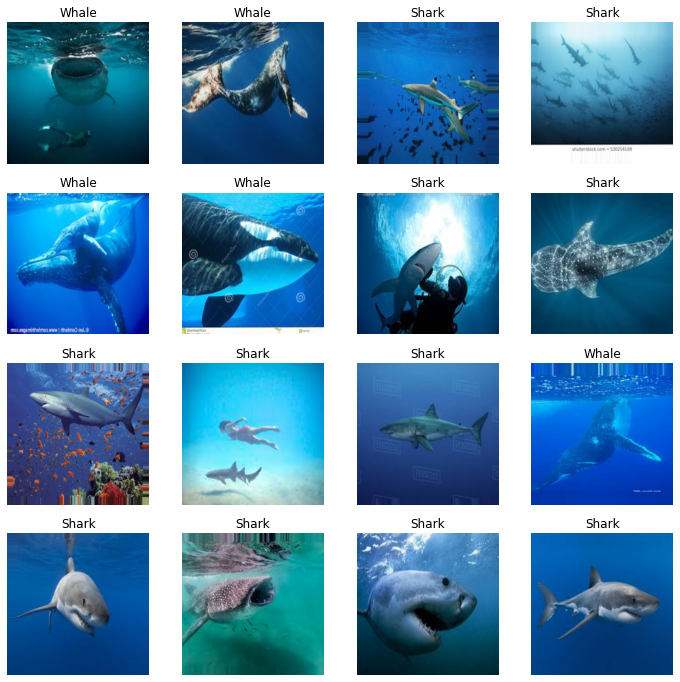

In [18]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

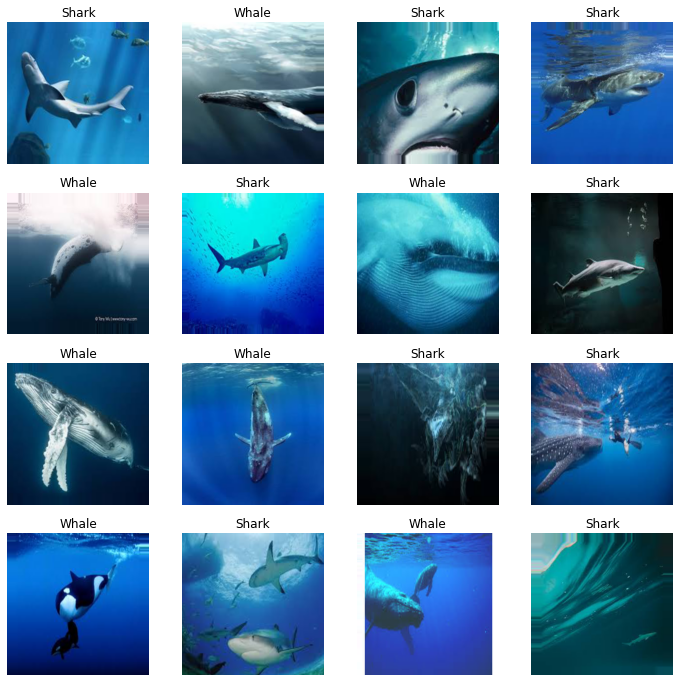

In [19]:
image_batch, label_batch = next(test_generator)
show_batch(image_batch, label_batch)

In [20]:
train_generator = train_datagen.flow_from_directory(
    pathlib.Path(data_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    interpolation='bicubic'
)
test_generator = test_datagen.flow_from_directory(
    pathlib.Path(data_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    interpolation='bicubic'
)

Found 632 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [21]:
model_1 = utils.make_model(img_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_classes=2)

### Составная модель на основе предобученной Inception ResNet v2

In [22]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Model)  multiple                  54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                98368     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 54,435,234
Trainable params: 98,498
Non-trainable params: 54,336,736
____________________________________________

In [23]:
def extract_data_from_generator(generator, steps):
  images = list()
  labels = list()
  for (im, l), _ in zip(generator, range(steps)):
    images.append(im)
    labels.append(l)
  return np.concatenate(images), np.concatenate(labels)

In [24]:
images, labels = extract_data_from_generator(train_generator, VALIDATION_STEPS)

### Визуализация признаков, сформированных Inception ResNet
### Кластеры, соответствующие нашим двум классам, перемешаны.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 984 samples in 0.017s...
[t-SNE] Computed neighbors for 984 samples in 0.155s...
[t-SNE] Computed conditional probabilities for sample 984 / 984
[t-SNE] Mean sigma: 0.169878
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.373928
[t-SNE] KL divergence after 1000 iterations: 0.659431


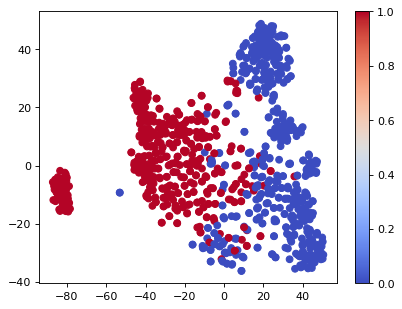

In [25]:
feature_extractor = utils.make_feature_extractor(model_1, 3)
utils.plot_feature_extraction(feature_extractor,
                        images,
                        labels,
                        train_generator,
                        n_images_to_plot=0
                        )

In [26]:
model_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),    
    metrics=[keras.metrics.SparseCategoricalAccuracy()]    
)

In [27]:
monitor = 'val_loss'
early_stopping = keras.callbacks.EarlyStopping(
    monitor=monitor,
    patience=5,
    mode='min',
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=('model_1.h5'),
    monitor=monitor,
    save_best_only=True,
    mode='min'
)

callbacks = [early_stopping, checkpoint]

In [28]:
history_1 = model_1.fit(
    x=test_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=100,
    validation_data=train_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    workers=6
)

Epoch 1/100
39/39 [==============================] - 523s 13s/step - loss: 0.7337 - sparse_categorical_accuracy: 0.5294 - val_loss: 0.6564 - val_sparse_categorical_accuracy: 0.6158
Epoch 2/100
39/39 [==============================] - 534s 14s/step - loss: 0.6919 - sparse_categorical_accuracy: 0.5735 - val_loss: 0.6045 - val_sparse_categorical_accuracy: 0.8023
Epoch 3/100
39/39 [==============================] - 546s 14s/step - loss: 0.6307 - sparse_categorical_accuracy: 0.6584 - val_loss: 0.5604 - val_sparse_categorical_accuracy: 0.8719
Epoch 4/100
39/39 [==============================] - 540s 14s/step - loss: 0.5910 - sparse_categorical_accuracy: 0.6969 - val_loss: 0.5196 - val_sparse_categorical_accuracy: 0.8832
Epoch 5/100
39/39 [==============================] - 563s 14s/step - loss: 0.5543 - sparse_categorical_accuracy: 0.7318 - val_loss: 0.4836 - val_sparse_categorical_accuracy: 0.8882
Epoch 6/100
39/39 [==============================] - 550s 14s/step - loss: 0.5028 - sparse_cate

In [29]:
history_1.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

### Обучение происходит. На обучающей выборке accuracy превысила 90%.

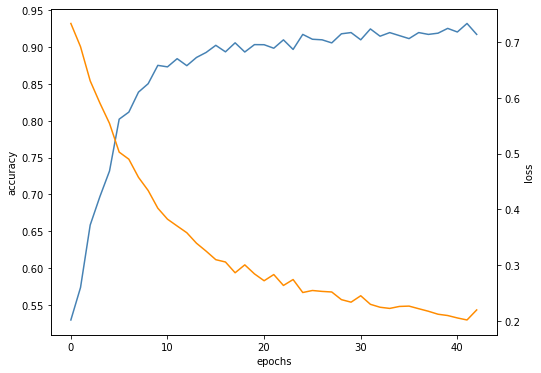

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history_1.history['sparse_categorical_accuracy'], color='steelblue')
ax.set_ylabel('accuracy');
ax.set_xlabel('epochs')
ax1= ax.twinx();
ax1.plot(history_1.history['loss'], color='darkorange')
ax1.set_ylabel('loss');

### На тестовой выборке accuracy также превысила 90%.
### Early stoping сработал после 42-ой эпохи. Примерно с 38-ой эпохи начинается переобучение.

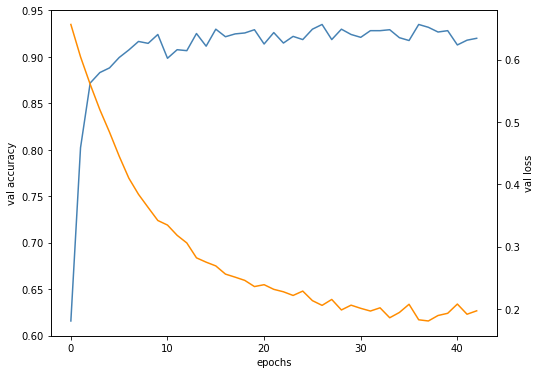

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history_1.history['val_sparse_categorical_accuracy'], color='steelblue')
ax.set_ylabel('val accuracy');
ax.set_xlabel('epochs')
ax1= ax.twinx()
ax1.plot(history_1.history['val_loss'], color='darkorange')
ax1.set_ylabel('val loss');

### Визуализация предсказаний составной сети на ОБУЧАЮЩЕЙ выборке.
### Примеры обоих классов по-прежнему перемешаны.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 976 samples in 0.000s...
[t-SNE] Computed neighbors for 976 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 976 / 976
[t-SNE] Mean sigma: 0.002367
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.785599
[t-SNE] KL divergence after 1000 iterations: 0.163147


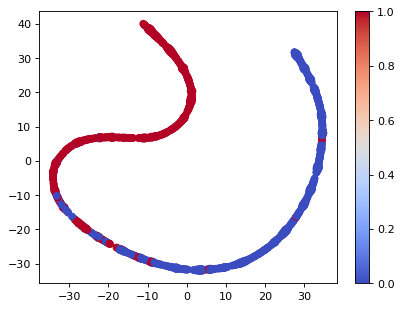

In [32]:
images, labels = extract_data_from_generator(train_generator, VALIDATION_STEPS)
feature_extractor = utils.make_feature_extractor(model_1, 0)
utils.plot_feature_extraction(feature_extractor,
                        images,
                        labels,
                        train_generator,
                        n_images_to_plot=0
                        )

### Визуализация предсказаний составной сети на ТЕСТОВОЙ выборке.
### Разделение кластеров не произошло.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 968 samples in 0.001s...
[t-SNE] Computed neighbors for 968 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 968 / 968
[t-SNE] Mean sigma: 0.002958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.218693
[t-SNE] KL divergence after 1000 iterations: 0.164994


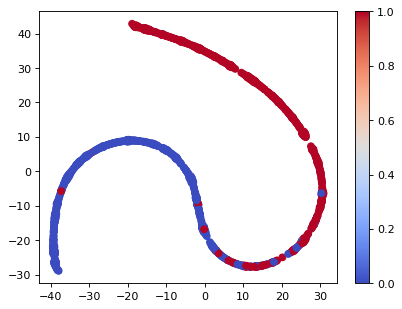

In [33]:
images, labels = extract_data_from_generator(test_generator, VALIDATION_STEPS)
feature_extractor = utils.make_feature_extractor(model_1, 0)
utils.plot_feature_extraction(feature_extractor,
                        images,
                        labels,
                        test_generator,
                        n_images_to_plot=0
                        )

### Теперь попробуем упростить модель

In [34]:
inception_resnet = keras.applications.InceptionResNetV2(include_top=False, weights='imagenet')
for layer in inception_resnet.layers:
    layer.trainable = False
input = keras.layers.Input((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
custom_model = inception_resnet(input)
custom_model = keras.layers.GlobalAveragePooling2D()(custom_model)
custom_model = keras.layers.Dense(16, activation='relu')(custom_model)
custom_model = keras.layers.Dropout(0.5)(custom_model)
predictions = keras.layers.Dense(2, activation='softmax')(custom_model)
model_2 = keras.Model(input, predictions)

In [35]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Model)  multiple                  54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                24592     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 54,361,362
Trainable params: 24,626
Non-trainable params: 54,336,736
__________________________________________

In [36]:
model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),    
    metrics=[keras.metrics.SparseCategoricalAccuracy()]    
)

In [37]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True  
)

In [38]:
train_generator = train_datagen.flow_from_directory(
    pathlib.Path(data_dir, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    interpolation='bicubic'
)
test_generator = test_datagen.flow_from_directory(
    pathlib.Path(data_dir, 'test'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 632 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [39]:
monitor = 'val_loss'
early_stopping = keras.callbacks.EarlyStopping(
    monitor=monitor,
    patience=5,
    mode='min',
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=('model_2.h5'),
    monitor=monitor,
    save_best_only=True,
    mode='min'
)

callbacks = [early_stopping, checkpoint]

In [40]:
history_2 = model_2.fit(
    x=train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=100,
    validation_data=test_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    workers=6
)

Epoch 1/100
39/39 [==============================] - 516s 13s/step - loss: 0.7646 - sparse_categorical_accuracy: 0.4589 - val_loss: 0.7140 - val_sparse_categorical_accuracy: 0.4469
Epoch 2/100
39/39 [==============================] - 518s 13s/step - loss: 0.7184 - sparse_categorical_accuracy: 0.5162 - val_loss: 0.6676 - val_sparse_categorical_accuracy: 0.6426
Epoch 3/100
39/39 [==============================] - 515s 13s/step - loss: 0.6707 - sparse_categorical_accuracy: 0.5836 - val_loss: 0.6309 - val_sparse_categorical_accuracy: 0.7831
Epoch 4/100
39/39 [==============================] - 516s 13s/step - loss: 0.6357 - sparse_categorical_accuracy: 0.6615 - val_loss: 0.5975 - val_sparse_categorical_accuracy: 0.8285
Epoch 5/100
39/39 [==============================] - 520s 13s/step - loss: 0.6114 - sparse_categorical_accuracy: 0.7062 - val_loss: 0.5646 - val_sparse_categorical_accuracy: 0.8729
Epoch 6/100
39/39 [==============================] - 518s 13s/step - loss: 0.5718 - sparse_cate

### Обучение заняло больше времени. При этом качество распознавания двух составных сетей (с добавлением 64-ёх и 16-ти полносвязных слоёв) практически одинаковое.

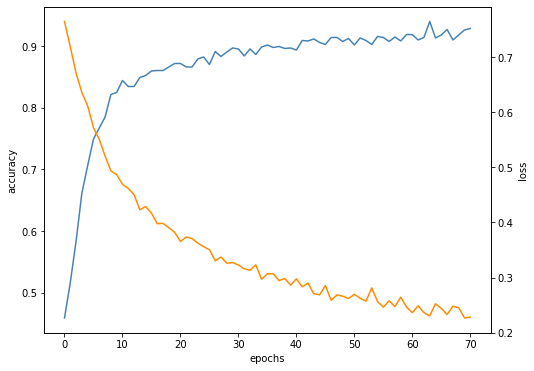

In [41]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history_2.history['sparse_categorical_accuracy'], color='steelblue')
ax.set_ylabel('accuracy');
ax.set_xlabel('epochs')
ax1= ax.twinx();
ax1.plot(history_2.history['loss'], color='darkorange')
ax1.set_ylabel('loss');

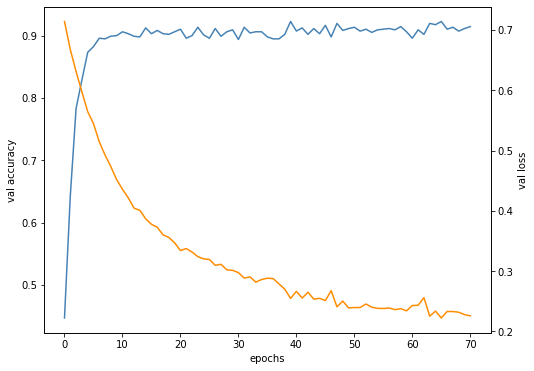

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history_2.history['val_sparse_categorical_accuracy'], color='steelblue')
ax.set_ylabel('val accuracy');
ax.set_xlabel('epochs')
ax1= ax.twinx()
ax1.plot(history_2.history['val_loss'], color='darkorange')
ax1.set_ylabel('val loss');